In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import re
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from datetime import datetime

!pip install tsfresh
import tsfresh
from tsfresh import extract_features as ts_extract_features
from tsfresh.feature_selection.selection import select_features

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.base import clone
from copy import deepcopy

color = sns.color_palette()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Set global variables

In [ ]:
_DATASET_ROOT_PATH = "/content/"

_PATH_TO_FEATURES = os.path.join(_DATASET_ROOT_PATH, "features.csv")
_PATH_TO_GT = os.path.join(_DATASET_ROOT_PATH, "patient_info.csv")
_PATH_TO_ACTIVITY_DATA = os.path.join(_DATASET_ROOT_PATH, "activity_data")

_VISUALIZE_PATIENT = os.path.join(_DATASET_ROOT_PATH, "activity_data", "patient_activity_57.csv")

In [ ]:
_RANDOM_SEED = 0
_NUMBER_OF_FOLDS = 10
_NUMBER_OF_FEATURES = 20
_TEST_RATIO = .30

In [ ]:
_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 0, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 1000, "criterion": "entropy",
    "max_features": "log2", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": _RANDOM_SEED,
    "class_weight": "balanced"
}

_PARAMS_XGB = {
    "n_estimators": 1000, "random_state": _RANDOM_SEED, "verbosity": 0,
    'objective':'binary:logistic', "learning_rate": .01
}

_PARAMS_LIGHTGB = {
    "n_estimators": 1000, "random_state": _RANDOM_SEED, "verbosity": 0,
    "objective": "binary", "learning_rate": .01
}

# Define functions

In [ ]:
def k_fold_model_evaluation( model_func, model_parameters, fit_parameters={}, n_splits=_NUMBER_OF_FOLDS, shuffle=True, random_state=_RANDOM_SEED ):

    y_preds, y_trues = [], []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state)

    models = [ ]
    k_fold_results = [ ]

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):

        model = model_func(**model_parameters)

        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index], X_TRAIN.iloc[fold_index]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = model.fit( x_fold_train, y_fold_train, **fit_parameters )
        models.append( deepcopy(model) )

        y_pred = model.predict_proba( x_fold_test )[:, 1]

        k_fold_results.append((list(y_pred), list(y_fold_test)))

        print(k_fold_results)

    return models, np.array(k_fold_results, dtype=object)

In [ ]:
def cv_confusion_matrix(k_fold_results, average=True):
    cm = np.zeros((2,2))
    for fold_index, (y_pred, y_true) in enumerate(k_fold_results):
        y_pred = np.round(y_pred)
        cm += metrics.confusion_matrix(y_true, y_pred)
    if average:
        return cm / len(k_fold_results)
    return cm

In [ ]:
def calculate_cv_results(cv_results):
    cv_metrics = defaultdict(list)
    for fold_index, fold_results in enumerate(cv_results):
        y_preds, y_trues = fold_results
        y_preds = np.round(np.array(y_preds, dtype=np.float32))
        cv_metrics["Fold"].append("Fold %i" % fold_index)
        cv_metrics["Accuracy"].append(metrics.accuracy_score(y_trues, y_preds))
        cv_metrics["Precision"].append(metrics.precision_score(y_trues, y_preds, average="binary"))
        cv_metrics["Recall"].append(metrics.recall_score(y_trues, y_preds, average="binary"))
        cv_metrics["F1-Score"].append(metrics.f1_score(y_trues, y_preds, average="binary"))
        cv_metrics["MCC"].append(metrics.matthews_corrcoef(y_trues, y_preds))
    return pd.DataFrame(data=dict(cv_metrics))

In [ ]:
def plot_au_curves(k_fold_results):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    precision = dict()
    recall = dict()
    average_precision = dict()

    all_preds = []
    all_trues = []

    for i, (y_pred, y_true) in enumerate(k_fold_results):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true, y_pred)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_true, y_pred)
        average_precision[i] = metrics.average_precision_score(y_true, y_pred)
        all_preds.extend(y_pred)
        all_trues.extend(y_true)

    fpr["mean"], tpr["mean"], _ = metrics.roc_curve(all_trues, all_preds)
    roc_auc['mean'] = metrics.auc(fpr['mean'], tpr['mean'])
    precision["mean"], recall["mean"], _ = metrics.precision_recall_curve(all_trues, all_preds)
    average_precision['mean'] = metrics.average_precision_score(all_trues, all_preds)


    fig = plt.figure(figsize=(18,6))

    # auroc
    ax1 = fig.add_subplot(121)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r',
            label='Chance', alpha=.8)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # for i in range(len(k_fold_results)):
    #     ax1.plot(fpr[i], tpr[i], color=colors[i],
    #         label=r'ROC Fold %i (AUC = %0.2f)' % (i+1,roc_auc[i]),
    #         lw=3, alpha=.5)

    ax1.plot(fpr['mean'], tpr['mean'], color='b',
            label=r'Mean ROC (AUC = %0.2f)' % (roc_auc['mean']),
            lw=4, alpha=.8)

    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Receiver Operating Characteristic Curve", size=20)
    plt.xlabel('False Positive Rate',size=20); plt.xticks(size=15)
    plt.ylabel('True Positive Rate',size=20); plt.yticks(size=15)
    ax1.legend(loc="lower right",prop={"size":15})

    # auprc
    ax2 = fig.add_subplot(122)

    # for i in range(len(k_fold_results)):
    #     ax2.step(recall[i], precision[i], where='post', color=colors[i],
    #              label=r'AP Fold %i (AP = %0.2f)' % (i+1,average_precision[i]),
    #              lw=3, alpha=.5)

    ax2.step(recall['mean'], precision['mean'], where='post', color='b',
            label=r'Mean AP (AP = %0.2f)' % (average_precision['mean']),
            lw=4, alpha=.8)

    ax2.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Precision Recall Curve", size=20)
    plt.xlabel('Recall',size=20); plt.xticks(size=15)
    plt.ylabel('Precision',size=20); plt.yticks(size=15)
    ax2.legend(loc="lower left",prop={"size":15})


    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax1_figure.png', bbox_inches=bbox)

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax2_figure_expanded.png', bbox_inches=bbox)

    plt.show()

# Visualize the dataset

In [ ]:
dataX = pd.read_csv(_PATH_TO_FEATURES, sep=";").sort_values(by="ID")
dataY = pd.read_csv(_PATH_TO_GT, sep=";").sort_values(by="ID")
dataY.columns

Index(['ID', 'SEX', 'AGE', 'ACC', 'ACC_TIME', 'ACC_DAYS', 'HRV', 'HRV_TIME',
       'HRV_HOURS', 'CPT_II', 'ADHD', 'ADD', 'BIPOLAR', 'UNIPOLAR', 'ANXIETY',
       'SUBSTANCE', 'OTHER', 'CT', 'MDQ_POS', 'WURS', 'ASRS', 'MADRS',
       'HADS_A', 'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab',
       'MED_Antipsych', 'MED_Anxiety_Benzo', 'MED_Sleep',
       'MED_Analgesics_Opioids', 'MED_Stimulants', 'filter_$'],
      dtype='object')

<ipython-input-11-5e3c12b9ec7a>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax5 = sns.distplot(dataY['MADRS'], kde=False)
<ipython-input-11-5e3c12b9ec7a>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax5 = sns.distplot(dataY['WURS'], kde=False)


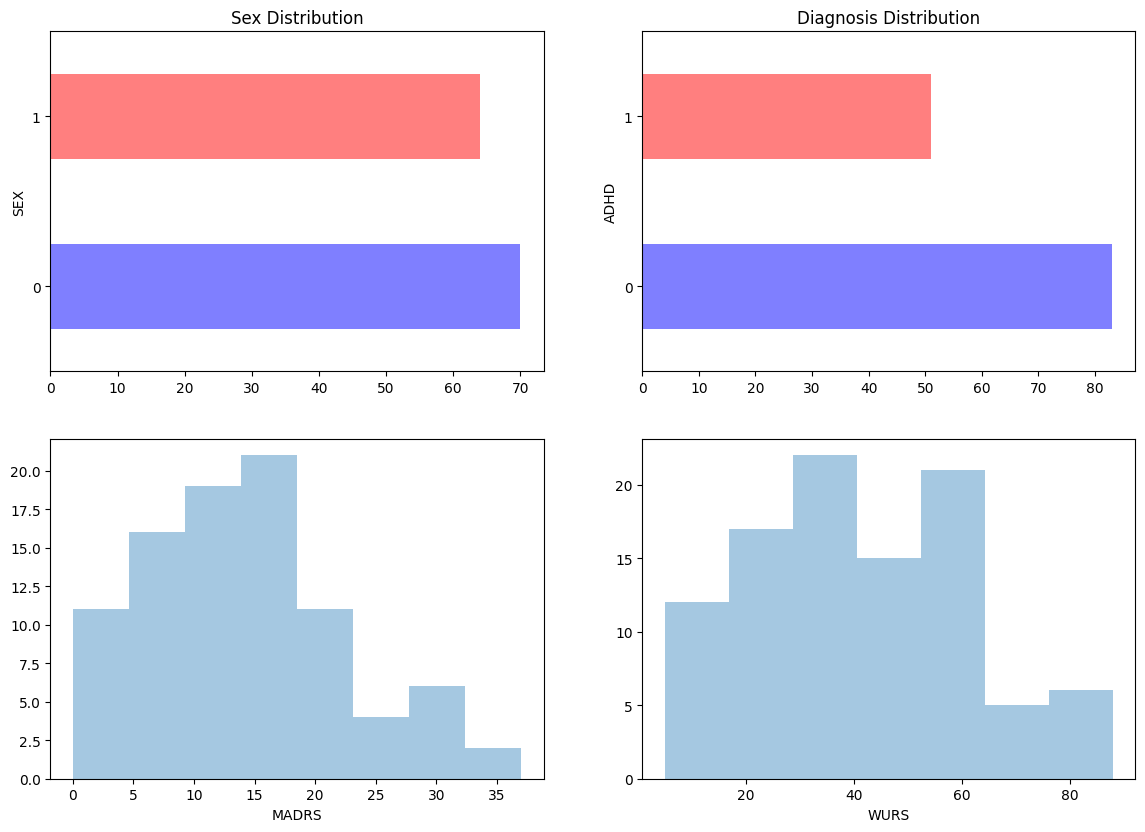

In [ ]:
fig = plt.figure(figsize=(14,15))

ax2 = fig.add_subplot(321)
ax2 = dataY['SEX'].value_counts().plot(kind='barh', color=['blue','red'], alpha=.5,
                                                  title='Sex Distribution')
ax3 = fig.add_subplot(322)
ax3 = dataY['ADHD'].value_counts().plot(kind='barh', color=['blue','red', 'green'], alpha=.5,
                                                  title='Diagnosis Distribution')
ax5 = fig.add_subplot(323)
ax5 = sns.distplot(dataY['MADRS'], kde=False)

ax5 = fig.add_subplot(324)
ax5 = sns.distplot(dataY['WURS'], kde=False)

<ipython-input-12-2e4b56c1bb32>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  patient_activity_data = pd.read_csv(_VISUALIZE_PATIENT, sep=";", parse_dates=["TIMESTAMP"], infer_datetime_format=True).sort_values(by="TIMESTAMP")


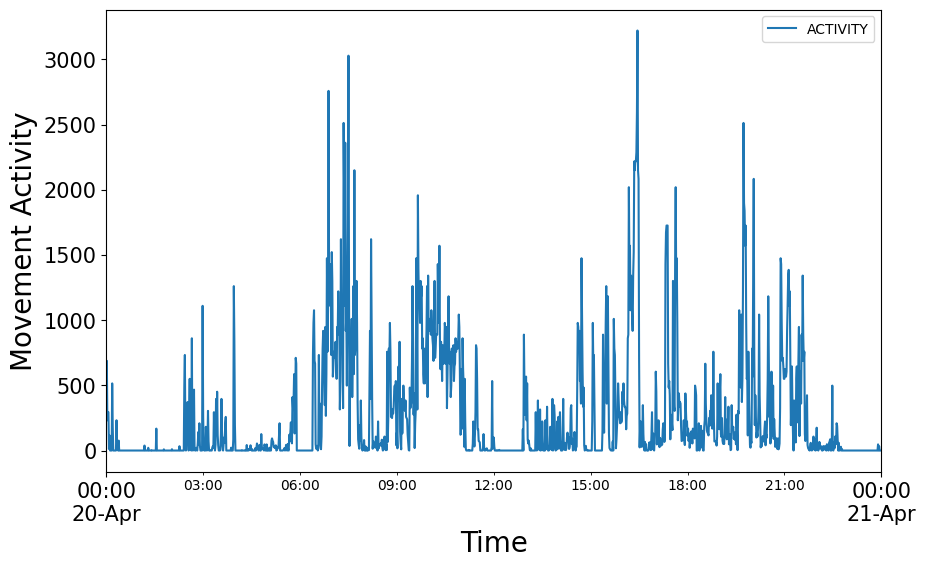

In [ ]:
patient_activity_data = pd.read_csv(_VISUALIZE_PATIENT, sep=";", parse_dates=["TIMESTAMP"], infer_datetime_format=True).sort_values(by="TIMESTAMP")
patient_activity_data = patient_activity_data.set_index(['TIMESTAMP'])

patient_activity_data.loc['2010-04-20 00:00:00':'2010-04-21 00:00:00'].plot(kind='line', figsize=(10,6))

plt.xlabel('Time',size=20); plt.xticks(size=15)
plt.ylabel('Movement Activity',size=20); plt.yticks(size=15)

plt.show()

# Find most important features

In [ ]:
dataX = pd.read_csv(_PATH_TO_FEATURES, sep=";").sort_values(by="ID")
dataY = pd.read_csv(_PATH_TO_GT, sep=";").sort_values(by="ID")

dataX = dataX.fillna(0)

# Remove JSON symbols from headers
dataX = dataX.rename(columns = lambda x:re.sub('"', '', x))
dataX = dataX.rename(columns = lambda x:re.sub(',', '', x))
dataY = dataY.rename(columns = lambda x:re.sub('"', '', x))
dataY = dataY.rename(columns = lambda x:re.sub(',', '', x))

# Match X and Y data
dataY = dataY[dataY["ID"].isin(dataX["ID"])]
dataX = dataX[dataX["ID"].isin(dataY["ID"])]

dataY = dataY.set_index("ID")
dataX = dataX.set_index("ID")

dataY = dataY["ADHD"].copy()

# Find relevant features using tsfresh
dataX = select_features(dataX, dataY)

scaler = StandardScaler(copy=True)
dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=_TEST_RATIO,
    random_state=_RANDOM_SEED,
    stratify=dataY)

# Logistic Regression

In [ ]:
lr_models, k_fold_results = k_fold_model_evaluation( LogisticRegression, _PARAMS_LORGREG )

[([0.00016741755140168085, 0.0006625191730057018, 0.0073470339134949075, 0.8416211217703118, 0.5939005441114027, 0.9348221290489105, 0.0013128842048202676, 0.3255743957279469, 0.3994993053178409], [0, 0, 1, 1, 1, 0, 0, 1, 0])]
[([0.00016741755140168085, 0.0006625191730057018, 0.0073470339134949075, 0.8416211217703118, 0.5939005441114027, 0.9348221290489105, 0.0013128842048202676, 0.3255743957279469, 0.3994993053178409], [0, 0, 1, 1, 1, 0, 0, 1, 0]), ([0.7247645713593328, 0.03809059196952819, 0.4808526108164649, 0.6091223251608284, 0.2743387675408997, 0.6100750794005764, 0.21503510137507206, 0.9128536062340825], [0, 0, 0, 0, 1, 1, 0, 1])]
[([0.00016741755140168085, 0.0006625191730057018, 0.0073470339134949075, 0.8416211217703118, 0.5939005441114027, 0.9348221290489105, 0.0013128842048202676, 0.3255743957279469, 0.3994993053178409], [0, 0, 1, 1, 1, 0, 0, 1, 0]), ([0.7247645713593328, 0.03809059196952819, 0.4808526108164649, 0.6091223251608284, 0.2743387675408997, 0.6100750794005764, 0.21

<ipython-input-16-c91ee703fd32>:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):


## Validation Evaluation

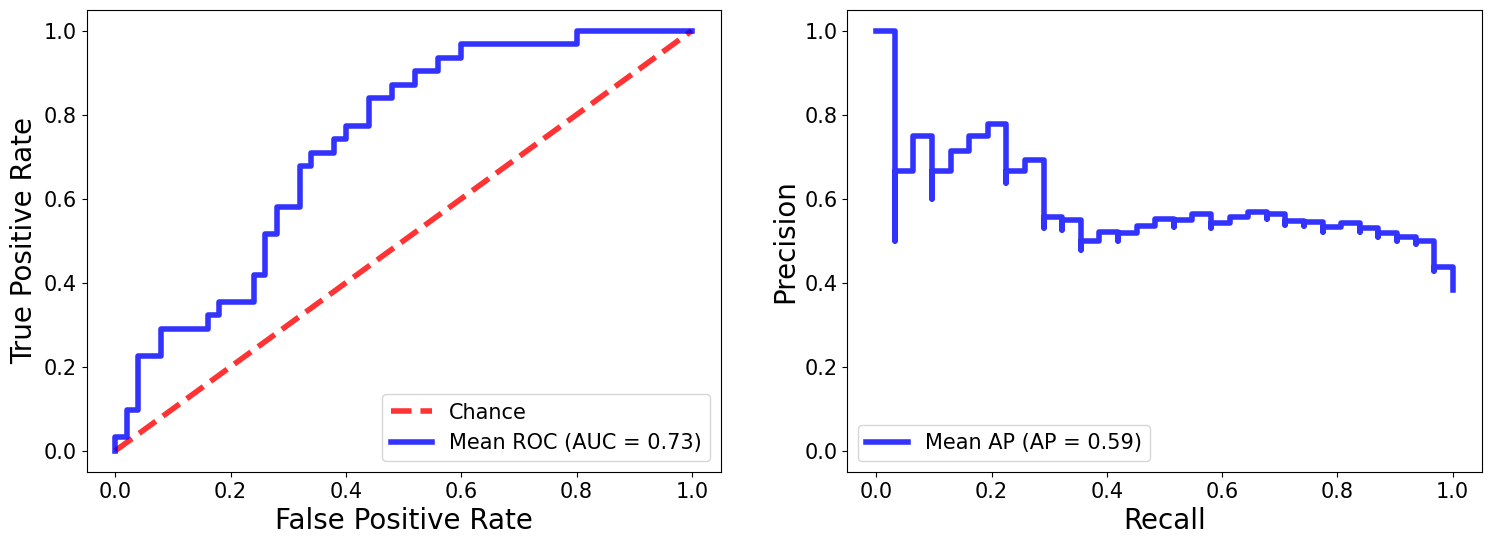

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,0.666667,0.500000,0.571429,0.316228
1,Fold 1,0.625000,0.500000,0.666667,0.571429,0.258199
2,Fold 2,0.750000,0.666667,0.666667,0.666667,0.466667
3,Fold 3,0.750000,0.666667,0.666667,0.666667,0.466667
4,Fold 4,0.750000,0.600000,1.000000,0.750000,0.600000
5,Fold 5,0.625000,0.500000,1.000000,0.666667,0.447214
6,Fold 6,0.500000,0.400000,0.666667,0.500000,0.066667
7,Fold 7,0.500000,0.333333,0.333333,0.333333,-0.066667
8,Fold 8,0.750000,0.666667,0.666667,0.666667,0.466667
9,Fold 9,0.875000,1.000000,0.666667,0.800000,0.745356


In [ ]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

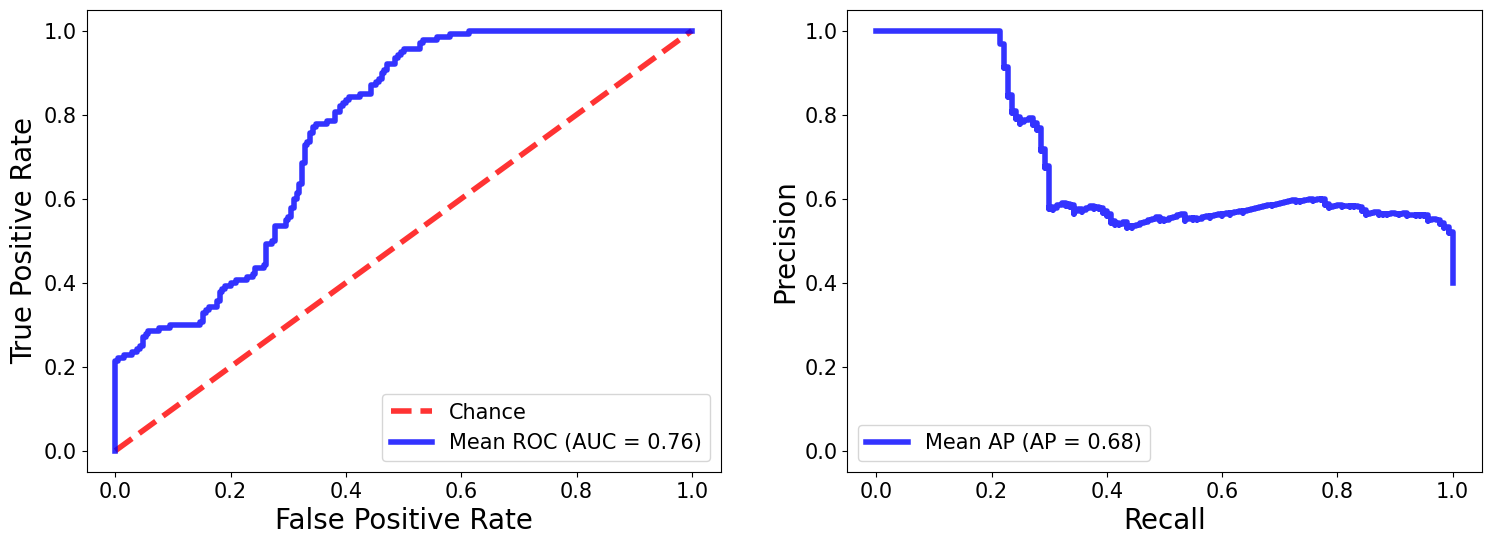

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.628571,0.545455,0.428571,0.480000,0.201008
1,Fold 1,0.714286,0.611111,0.785714,0.687500,0.443422
2,Fold 2,0.714286,0.625000,0.714286,0.666667,0.421464
3,Fold 3,0.714286,0.625000,0.714286,0.666667,0.421464
4,Fold 4,0.742857,0.631579,0.857143,0.727273,0.515122
5,Fold 5,0.685714,0.578947,0.785714,0.666667,0.398049
6,Fold 6,0.628571,0.526316,0.714286,0.606061,0.280976
7,Fold 7,0.685714,0.588235,0.714286,0.645161,0.373408
8,Fold 8,0.685714,0.588235,0.714286,0.645161,0.373408
9,Fold 9,0.714286,0.611111,0.785714,0.687500,0.443422


In [ ]:
test_cv_results = []
for model in lr_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)

In [ ]:
cv_confusion_matrix(test_cv_results)

array([[14.1,  6.9],
       [ 3.9, 10.1]])

# Random Forest

In [ ]:
rf_models, k_fold_results = k_fold_model_evaluation( RandomForestClassifier, _PARAMS_RFC )

<ipython-input-16-c91ee703fd32>:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):


InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

## Validation Evaluation

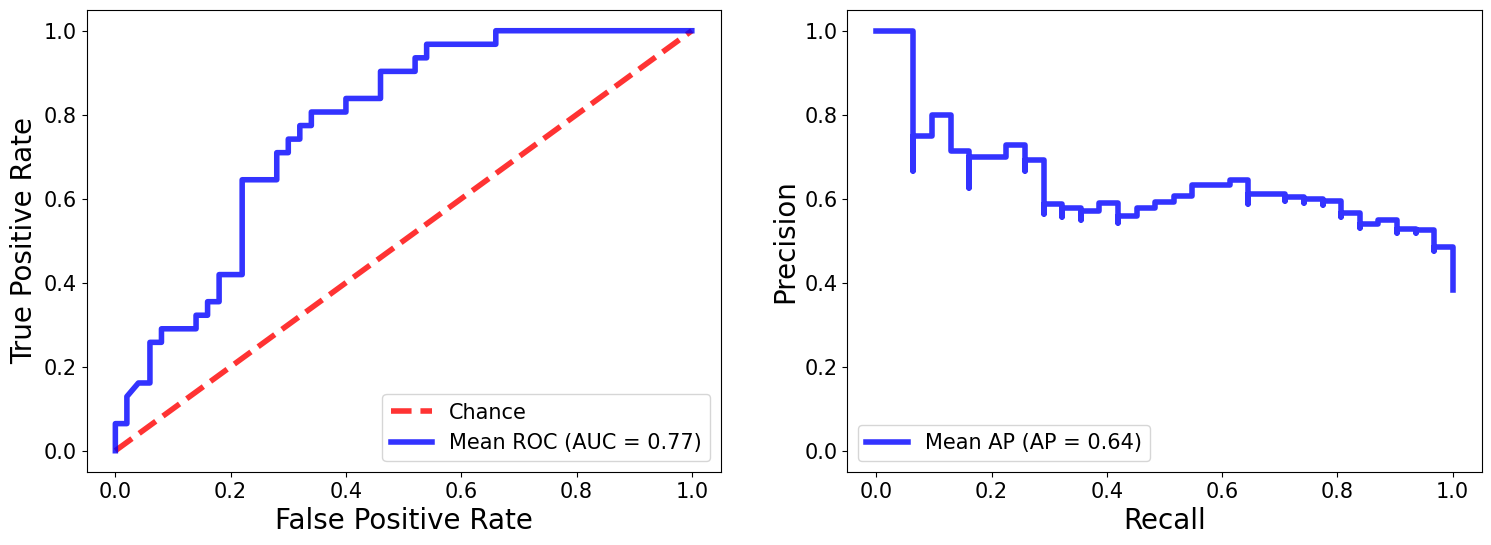

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,1.000000,0.250000,0.400000,0.395285
1,Fold 1,0.750000,0.666667,0.666667,0.666667,0.466667
2,Fold 2,0.750000,0.666667,0.666667,0.666667,0.466667
3,Fold 3,0.625000,0.500000,0.666667,0.571429,0.258199
4,Fold 4,0.750000,0.600000,1.000000,0.750000,0.600000
5,Fold 5,0.750000,0.600000,1.000000,0.750000,0.600000
6,Fold 6,0.625000,0.500000,0.666667,0.571429,0.258199
7,Fold 7,0.625000,0.500000,0.666667,0.571429,0.258199
8,Fold 8,0.875000,0.750000,1.000000,0.857143,0.774597
9,Fold 9,0.500000,0.000000,0.000000,0.000000,-0.292770


In [ ]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

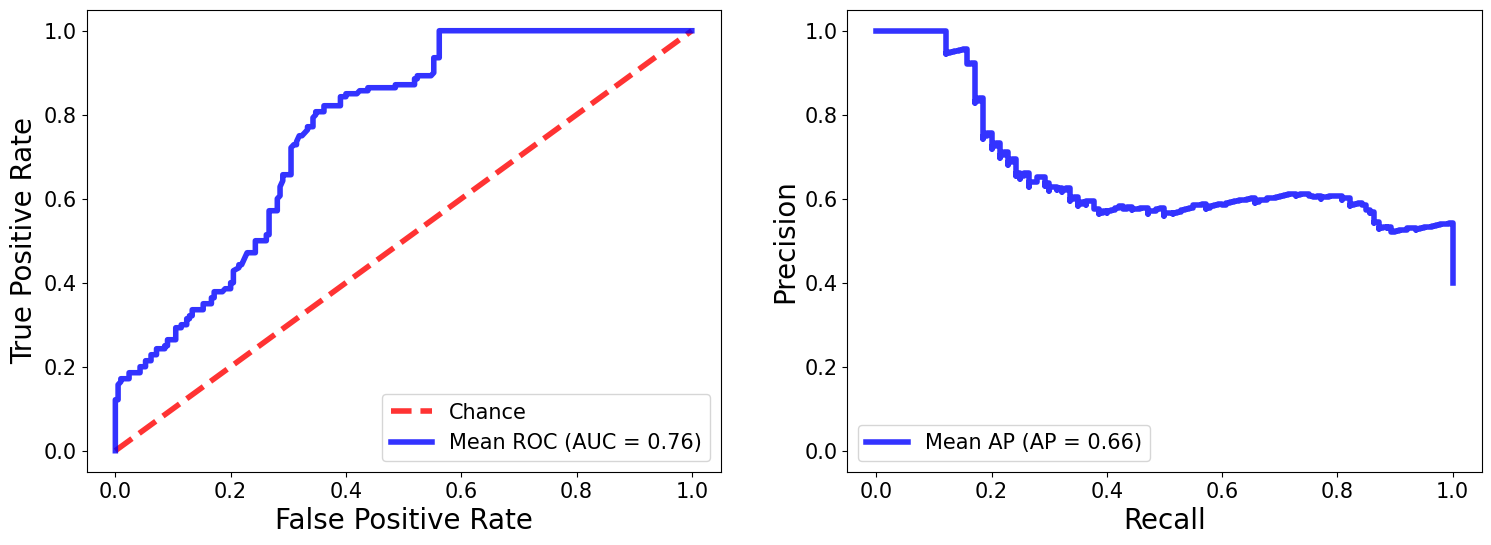

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.657143,0.625000,0.357143,0.454545,0.250000
1,Fold 1,0.657143,0.571429,0.571429,0.571429,0.285714
2,Fold 2,0.657143,0.571429,0.571429,0.571429,0.285714
3,Fold 3,0.657143,0.583333,0.500000,0.538462,0.270310
4,Fold 4,0.685714,0.615385,0.571429,0.592593,0.337963
5,Fold 5,0.628571,0.538462,0.500000,0.518519,0.217262
6,Fold 6,0.657143,0.562500,0.642857,0.600000,0.304390
7,Fold 7,0.657143,0.583333,0.500000,0.538462,0.270310
8,Fold 8,0.628571,0.533333,0.571429,0.551724,0.235702
9,Fold 9,0.628571,0.538462,0.500000,0.518519,0.217262


In [ ]:
test_cv_results = []
for model in rf_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)

# XGBoost

## Model Training

In [ ]:
xgb_models, k_fold_results = k_fold_model_evaluation( xgb.XGBClassifier, _PARAMS_XGB )

<ipython-input-37-c91ee703fd32>:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):


[([0.01100571, 0.0155616375, 0.13350187, 0.924328, 0.26738995, 0.25441933, 0.011653928, 0.04524413, 0.017718166], [0, 0, 1, 1, 1, 0, 0, 1, 0])]
[([0.01100571, 0.0155616375, 0.13350187, 0.924328, 0.26738995, 0.25441933, 0.011653928, 0.04524413, 0.017718166], [0, 0, 1, 1, 1, 0, 0, 1, 0]), ([0.9139359, 0.035292137, 0.047384042, 0.66270024, 0.44904992, 0.27669412, 0.015471555, 0.34951925], [0, 0, 0, 0, 1, 1, 0, 1])]
[([0.01100571, 0.0155616375, 0.13350187, 0.924328, 0.26738995, 0.25441933, 0.011653928, 0.04524413, 0.017718166], [0, 0, 1, 1, 1, 0, 0, 1, 0]), ([0.9139359, 0.035292137, 0.047384042, 0.66270024, 0.44904992, 0.27669412, 0.015471555, 0.34951925], [0, 0, 0, 0, 1, 1, 0, 1]), ([0.008638112, 0.00627261, 0.010238353, 0.7980347, 0.007152785, 0.88631225, 0.60481405, 0.0139494715], [0, 0, 0, 1, 0, 1, 0, 1])]
[([0.01100571, 0.0155616375, 0.13350187, 0.924328, 0.26738995, 0.25441933, 0.011653928, 0.04524413, 0.017718166], [0, 0, 1, 1, 1, 0, 0, 1, 0]), ([0.9139359, 0.035292137, 0.047384042,

## Validation Evaluation

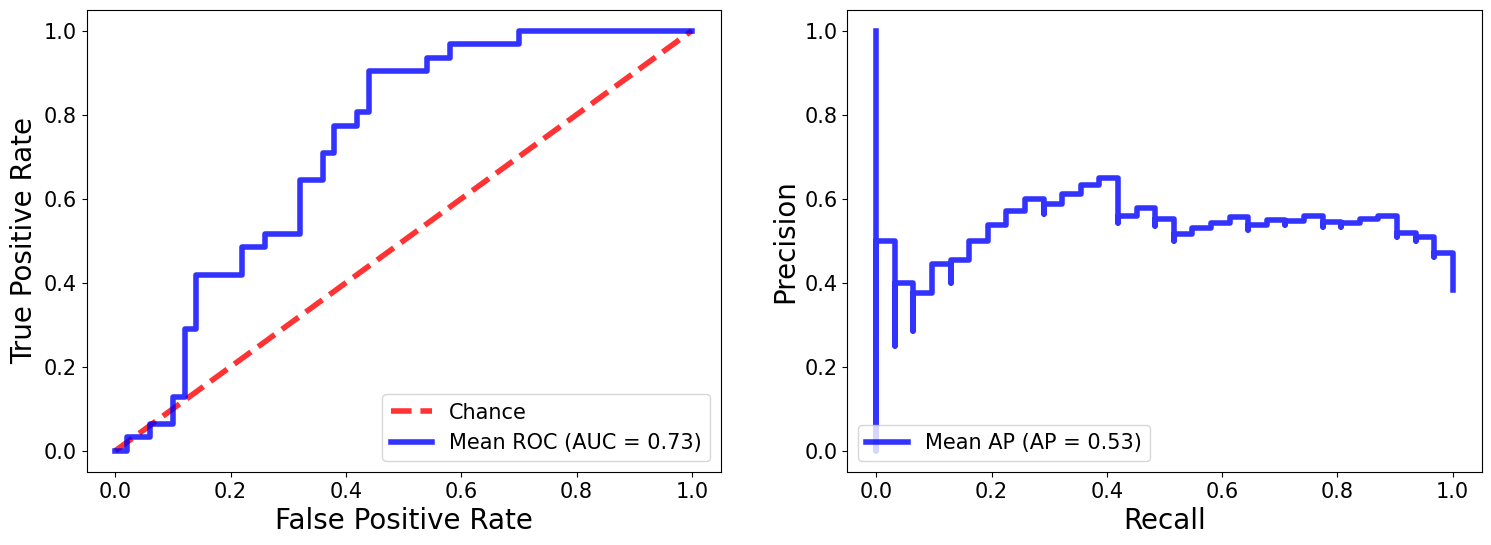

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,1.000000,0.250000,0.400000,0.395285
1,Fold 1,0.375000,0.000000,0.000000,0.000000,-0.447214
2,Fold 2,0.750000,0.666667,0.666667,0.666667,0.466667
3,Fold 3,0.750000,0.666667,0.666667,0.666667,0.466667
4,Fold 4,0.375000,0.250000,0.333333,0.285714,-0.258199
5,Fold 5,0.875000,0.750000,1.000000,0.857143,0.774597
6,Fold 6,0.375000,0.250000,0.333333,0.285714,-0.258199
7,Fold 7,0.625000,0.500000,0.666667,0.571429,0.258199
8,Fold 8,0.875000,1.000000,0.666667,0.800000,0.745356
9,Fold 9,0.875000,1.000000,0.666667,0.800000,0.745356


In [ ]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

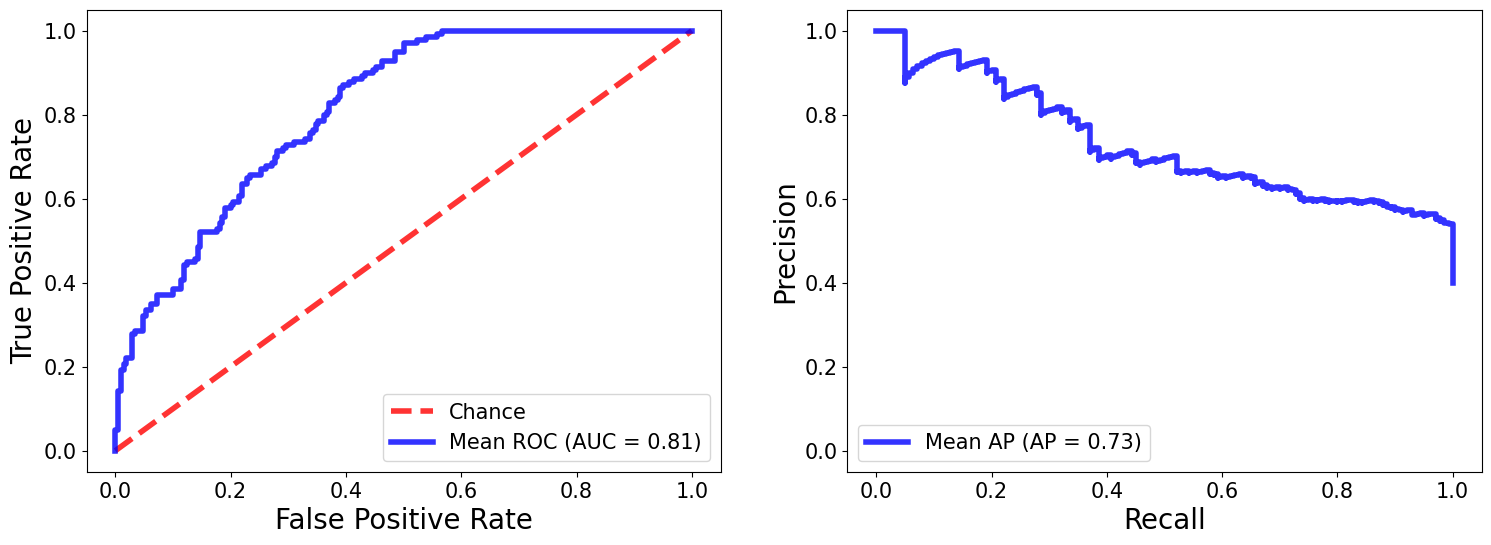

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.742857,0.727273,0.571429,0.640000,0.452267
1,Fold 1,0.685714,0.636364,0.500000,0.560000,0.326637
2,Fold 2,0.685714,0.615385,0.571429,0.592593,0.337963
3,Fold 3,0.771429,0.714286,0.714286,0.714286,0.523810
4,Fold 4,0.771429,0.714286,0.714286,0.714286,0.523810
5,Fold 5,0.742857,0.692308,0.642857,0.666667,0.458664
6,Fold 6,0.742857,0.666667,0.714286,0.689655,0.471405
7,Fold 7,0.685714,0.588235,0.714286,0.645161,0.373408
8,Fold 8,0.714286,0.666667,0.571429,0.615385,0.393179
9,Fold 9,0.685714,0.600000,0.642857,0.620690,0.353553


In [ ]:
test_cv_results = []
for model in xgb_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)

# LightGBM

In [ ]:
gbm_models, k_fold_results = k_fold_model_evaluation( lgb.LGBMClassifier, _PARAMS_LIGHTGB )

<ipython-input-37-c91ee703fd32>:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

## Validation Evaluation

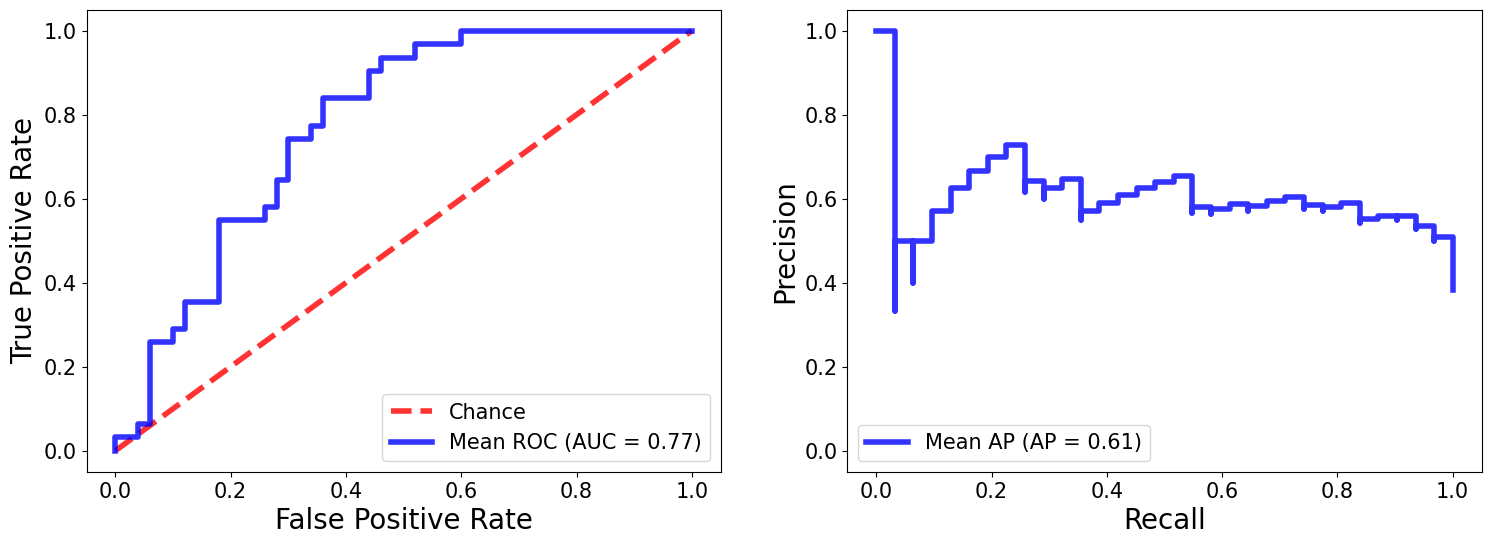

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.666667,1.000000,0.250000,0.400000,0.395285
1,Fold 1,0.625000,0.500000,0.666667,0.571429,0.258199
2,Fold 2,0.875000,1.000000,0.666667,0.800000,0.745356
3,Fold 3,0.750000,0.666667,0.666667,0.666667,0.466667
4,Fold 4,0.625000,0.500000,1.000000,0.666667,0.447214
5,Fold 5,0.875000,0.750000,1.000000,0.857143,0.774597
6,Fold 6,0.375000,0.250000,0.333333,0.285714,-0.258199
7,Fold 7,0.500000,0.400000,0.666667,0.500000,0.066667
8,Fold 8,0.750000,0.666667,0.666667,0.666667,0.466667
9,Fold 9,0.875000,1.000000,0.666667,0.800000,0.745356


In [ ]:
plot_au_curves(k_fold_results)
calculate_cv_results(k_fold_results)

## Test Evaluation

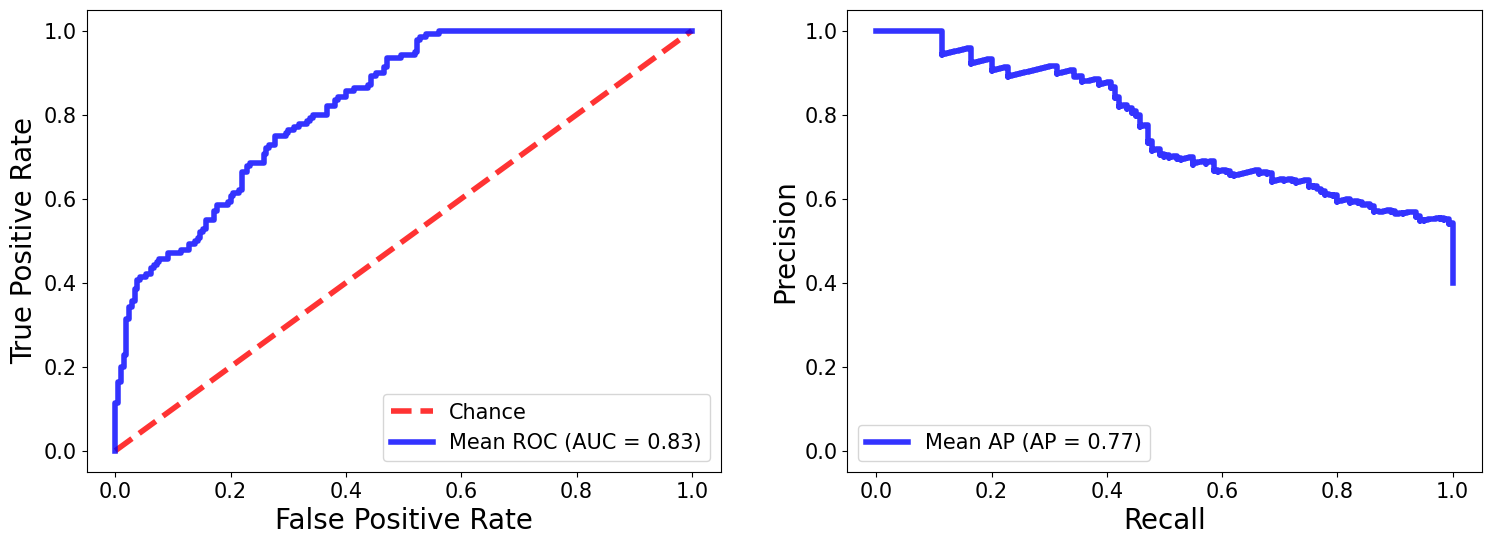

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.714286,0.750000,0.428571,0.545455,0.388889
1,Fold 1,0.685714,0.600000,0.642857,0.620690,0.353553
2,Fold 2,0.685714,0.615385,0.571429,0.592593,0.337963
3,Fold 3,0.714286,0.642857,0.642857,0.642857,0.404762
4,Fold 4,0.742857,0.666667,0.714286,0.689655,0.471405
5,Fold 5,0.742857,0.666667,0.714286,0.689655,0.471405
6,Fold 6,0.685714,0.600000,0.642857,0.620690,0.353553
7,Fold 7,0.800000,0.769231,0.714286,0.740741,0.579365
8,Fold 8,0.714286,0.625000,0.714286,0.666667,0.421464
9,Fold 9,0.742857,0.727273,0.571429,0.640000,0.452267


In [ ]:
test_cv_results = []
for model in gbm_models:
    test_cv_results.append((model.predict_proba(X_TEST)[:, 1], list(Y_TEST)))
plot_au_curves(test_cv_results)
calculate_cv_results(test_cv_results)

## Feed Forward Neural Network (FFNN)

In [ ]:
!pip install tensorflow pandas scikit-learn matplotlib

# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5629 - loss: 0.7215 - val_accuracy: 0.5714 - val_loss: 0.5878
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6390 - loss: 0.5857 - val_accuracy: 0.6286 - val_loss: 0.4921
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7392 - loss: 0.4936 - val_accuracy: 0.6286 - val_loss: 0.4848
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7079 - loss: 0.5220 - val_accuracy: 0.6286 - val_loss: 0.4963
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7034 - loss: 0.4861 - val_accuracy: 0.6286 - val_loss: 0.5070
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7190 - loss: 0.4805 - val_accuracy: 0.6857 - val_loss: 0.5140
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6839 - loss: 0.4618 - val_accuracy: 0.7143 - val_loss: 0.5247
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7912 - loss: 0.4034 - val_accuracy: 0.6571 - val_loss: 0.5350
Epoch 9/50

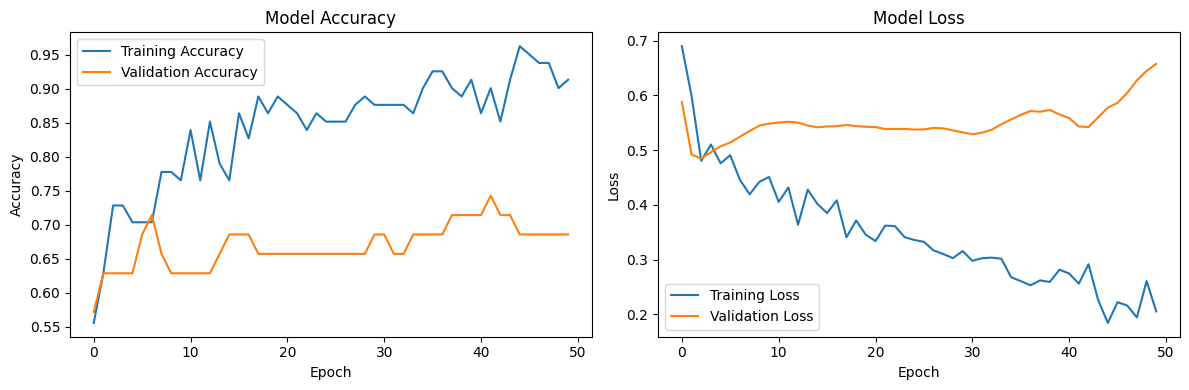

In [ ]:
# Build the Feed Forward Neural Network
model = Sequential([
    Dense(128, activation='relu', input_dim=X_TRAIN.shape[1]),
    Dropout(0.3),  # Dropout layer for regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Adjust units for the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

num_classes = 2  # Update this based on the number of classes in your dataset
Y_TRAIN = tf.keras.utils.to_categorical(Y_TRAIN, num_classes)
Y_TEST = tf.keras.utils.to_categorical(Y_TEST, num_classes)

# Train the model
history = model.fit(X_TRAIN, Y_TRAIN,
                    validation_data=(X_TEST, Y_TEST),
                    epochs=50,
                    batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_TEST, Y_TEST)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict and evaluate
y_pred = model.predict(X_TEST)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_TEST, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Visualize Training and Validation Accuracy/Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Long Short-Term Memory (LSTM)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.3880 - mae: 0.4066 - val_loss: 0.3521 - val_mae: 0.4013
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3762 - mae: 0.4245 - val_loss: 0.3143 - val_mae: 0.3962
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3226 - mae: 0.3994 - val_loss: 0.2797 - val_mae: 0.3891
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2732 - mae: 0.3776 - val_loss: 0.2471 - val_mae: 0.3795
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2686 - mae: 0.4031 - val_loss: 0.2160 - val_mae: 0.3660
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2196 - mae: 0.3744 - val_loss: 0.1901 - val_mae: 0.3493
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1853 - mae: 0.3531 - val_loss: 0.1720 - val_mae: 0.3415
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1760 - mae: 0.3486 - val_loss: 0.1645 - val_mae: 0.3443
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1713 - mae: 0.3438 - val_loss: 

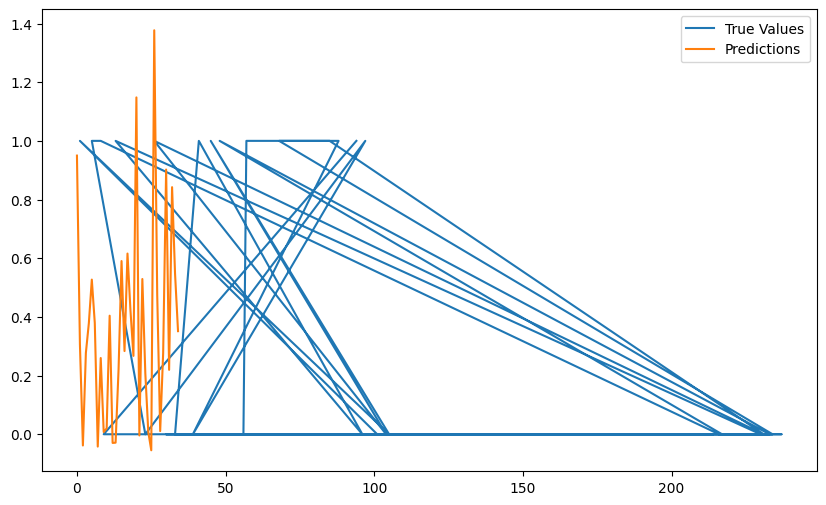

In [ ]:
sequence_length = 10
num_features = 1
timesteps = 1
features = 52

X_TRAIN = X_TRAIN.reshape((81, timesteps, features))

# Scale data
scaler = StandardScaler()
X_TRAIN = scaler.fit_transform(X_TRAIN.reshape(-1, X_TRAIN.shape[-1])).reshape(X_TRAIN.shape)
X_TEST = X_TEST.reshape((X_TEST.shape[0], timesteps, features))

# Build the LSTM model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_TRAIN.shape[1], X_TRAIN.shape[2]), return_sequences=True),
    Dropout(0.2),  # Dropout to avoid overfitting
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_TRAIN, Y_TRAIN,
                    validation_data=(X_TEST, Y_TEST),
                    epochs=50,
                    batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_TEST, Y_TEST)
print(f"Test MAE: {mae}")

# Predict
y_pred = model.predict(X_TEST)

# Plot predictions vs true values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(Y_TEST, label='True Values')
plt.plot(y_pred, label='Predictions')
plt.legend()
plt.show()

## Convolutional Neural Network (CNN)